In [8]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
from utils import SingleNeuron_Data, Network_Data
import multiprocessing
device = torch.device("cuda:0")
num_cores = multiprocessing.cpu_count()

In [9]:
def add_noise(net):
    rate = 10
    weight = 0.01
    # Add Poisson drives
    weights_ampa_d1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight}
    rates_d1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate}

    net.add_poisson_drive(
        name='distal', tstart=0, tstop=None, rate_constant=rates_d1, location='distal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_d1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=1, conn_seed=2)

    weights_ampa_p1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight, 'L5_basket': weight}
    rates_p1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate, 'L5_basket': rate}

    net.add_poisson_drive(
        name='proximal', tstart=0, tstop=None, rate_constant=rates_p1, location='proximal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_p1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=3, conn_seed=4)

In [10]:
%%capture
hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
params.update({'N_pyr_x': 3, 'N_pyr_y': 3})
net = calcium_model(params)
add_noise(net)

dt = 0.5
dpl = simulate_dipole(net, dt=dt, tstop=1000, record_vsec='all', record_isec='all')

In [11]:
net_build = NetworkBuilder(net)

Building the NEURON model
[Done]


In [58]:
class CellType_Dataset(torch.utils.data.Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, net, cell_type='L5_pyramidal', data_step_size=1,
                 window_size=100, input_spike_scaler=None, vsec_scaler=None, isec_scaler=None,
                 device='cpu'):
        
        network_data = Network_Data(net)
        self.cell_type = cell_type
        self.num_cells = len(network_data.net.gid_ranges[self.cell_type])
        self.data_step_size = data_step_size
        self.window_size = window_size
        self.device = device

        self.vsec_names = network_data.neuron_data_dict[list(net.gid_ranges[cell_type])[0]].vsec_names
        self.isec_names = network_data.neuron_data_dict[list(net.gid_ranges[cell_type])[0]].isec_names

        self.input_spike_list, self.vsec_list, self.isec_list = self.process_data(network_data)
        assert len(self.input_spike_list) == len(self.vsec_list) == len(self.isec_list) == self.num_cells

        if input_spike_scaler is None:
            self.input_spike_scaler = StandardScaler()
            self.input_spike_scaler.fit(np.vstack(self.input_spike_list))
        else:
            self.input_spike_scaler = input_spike_scaler
        
        if vsec_scaler is None:
            self.vsec_scaler = StandardScaler()
            self.vsec_scaler.fit(np.vstack(self.vsec_list))
        else:
            self.vsec_scaler = vsec_scaler
        
        if isec_scaler is None:
            self.isec_scaler = StandardScaler()
            self.isec_scaler.fit(np.vstack(self.isec_list))
        else:
            self.isec_scaler = isec_scaler
 

        self.input_spike_list, self.vsec_list, self.isec_list = self.transform_data()
        
        # X is one step behind y
        # self.X_tensor = self.input_spike_unfolded[:, :-1, :]
        # self.y_tensor = self.vsec_unfolded[:, 1:, :]
        # assert self.X_tensor.shape[0] == self.y_tensor.shape[0]
        # self.num_samples = self.X_tensor.shape[0]

        # self.X_tensor = self.X_tensor.float().to(self.device)
        # self.y_tensor = self.y_tensor.float().to(self.device)

    
    def __len__(self):
        #'Denotes the total number of samples'
        return self.num_samples

    def __getitem__(self, slice_index):
        neuron_idx = slice_index // self.num_cells
        slice_index = slice_index % self.num_cells

        X_data = self.input_spike_list[neuron_idx][slice_index,:]
        y_data = self.input_spike_list[neuron_idx][slice_index,:]

        print(X_data.dim())
        if X_data.dim() == 2:
            X_data = X_data.unsqueeze(0)
            y_data = y_data.unsqueeze(0)

        X_data = X_data.unfold(0, self.window_size, self.data_step_size).transpose(1,2)
        y_data = y_data.unfold(0, self.window_size, self.data_step_size).transpose(1,2)
        

        return self.X_data[:, :-1, :], self.y_data[:, 1:, :]
    

    def process_data(self, network_data):
        gid_list = network_data.net.gid_ranges[self.cell_type]
        input_spike_list, vsec_list, isec_list = list(), list(), list()
        for gid in gid_list:
            input_spike_list.append(network_data.input_spike_dict[gid].T)
            vsec_list.append(network_data.neuron_data_dict[gid].vsec_array.T)
            isec_list.append(network_data.neuron_data_dict[gid].isec_array.T)
        
        return input_spike_list, vsec_list, isec_list

    def transform_data(self):
        input_spike_transform_list, vsec_transform_list, isec_transform_list = list(), list(), list()
        for idx in range(self.num_cells):
            input_spike_transformed = self.input_spike_scaler.transform(self.input_spike_list[idx])
            input_spike_transformed = torch.from_numpy(input_spike_transformed)
            input_spike_transform_list.append(input_spike_transformed)


            vsec_transformed = self.vsec_scaler.transform(self.vsec_list[idx])
            vsec_transformed = torch.from_numpy(vsec_transformed)
            vsec_transform_list.append(vsec_transformed)

            isec_transformed = self.isec_scaler.transform(self.isec_list[idx])
            isec_transformed = torch.from_numpy(isec_transformed)
            isec_transform_list.append(isec_transformed)

        return input_spike_transform_list, vsec_transform_list, isec_transform_list



    # def unfold_data(self):
    #     input_spike_unfold_list, vsec_unfold_list, isec_unfold_list = list(), list(), list()
    #     for idx in range(self.num_cells):
    #         # Input spikes
    #         input_spike_transformed = self.input_spike_scaler.transform(self.input_spike_list[idx])
    #         input_spike_transformed = torch.from_numpy(input_spike_transformed)
    #         input_spike_unfolded = input_spike_transformed.unfold(0, self.window_size + 1, self.data_step_size).transpose(1,2)
    #         input_spike_unfold_list.append(input_spike_unfolded)

    #         # Voltages
    #         vsec_transformed = self.vsec_scaler.transform(self.vsec_list[idx])
    #         vsec_transformed = torch.from_numpy(vsec_transformed)
    #         vsec_unfolded = vsec_transformed.unfold(0, self.window_size + 1, self.data_step_size).transpose(1,2)
    #         vsec_unfold_list.append(vsec_unfolded)

    #         # Currents
    #         isec_transformed = self.isec_scaler.transform(self.isec_list[idx])
    #         isec_transformed = torch.from_numpy(isec_transformed)
    #         isec_unfolded = isec_transformed.unfold(0, self.window_size + 1, self.data_step_size).transpose(1,2)
    #         isec_unfold_list.append(isec_unfolded)

    #     input_spike_unfolded = torch.concat(input_spike_unfold_list, dim=0)
    #     vsec_unfolded = torch.concat(vsec_unfold_list, dim=0)
    #     isec_unfolded = torch.concat(isec_unfold_list, dim=0)

    #     return input_spike_unfolded, vsec_unfolded, isec_unfolded

In [59]:
# net_data = Network_Data(net)
training_set = CellType_Dataset(net, cell_type='L2_pyramidal')

In [60]:
training_set[:2]

TypeError: 'slice' object is not iterable

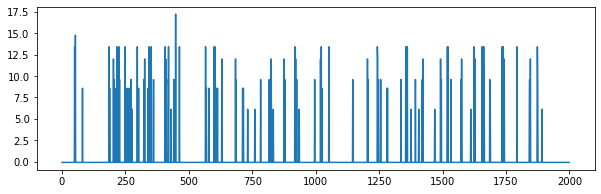

In [11]:
plt.figure(figsize=(10,3))
plt.plot(training_set[:2000][0][:,-1,13].detach().cpu().numpy())